# INRC Tutorial: RL in Nengo


### 1. Theoretical background on PES rule

- $E = 1/2 \int (x-\hat{x})^2 dx$


- $\delta E/\delta d_i = (x-\hat{x})a_i$ (as usual for finding decoders)


- So, to move down the gradient:
    - $\Delta d_i = -\kappa (x - \hat{x})a_i$ (NEF notation)


- How do we make it realistic?
    - Need weights
    
    
- The NEF tells us:
    - $\omega_{ij} =  d_i \cdot e_j$
    - $\Delta \omega_{ij} = \kappa a_i E \cdot e_j $ 


- What's $ E \cdot e_j$?
    - That's the current that this neuron would get if it had $E$ as an input
    - But we don't want this current to drive the neuron
    - Rather, we want it to change the weight
    - It's a *modulatory* input


- This is the "Prescribed Error Sensitivity" PES rule
    - Any model in the NEF could use this instead of computing decoders
    - Requires some other neural group computing the error $E$
    - Used in Spaun for Q-value learning (reinforcement task)

### 2. A simple grid world example

Some preliminary details:

- the agent has four actions (go up, go right, go left, go down)
- state is encoded as 25D vector, Q-values are a 4D function of this state 
- reward is +1 for getting to goal state, -1 for hitting a wall, 0 elsewhere
- the error signal is $\Delta Q(s,a) = \alpha (R + Q(s', a') - Q(s, a))$
- connections into error signal ensemble use fast tau for $Q(s', a')$, slow tau for $Q(s, a)$.

First, we'll define some parameters for models, the environment, and some helper functions for managing the environment.

In [11]:
import td_grid
import nengo
import numpy as np
import matplotlib.pyplot as plt
from utils import weight_init
import pandas as pd


# high-level configuration
stepsize = 10 # milleseconds between each action
n_neurons = 2500
n_actions = 4

fast_tau = 0
slow_tau = 0.01

# build the world and add the agent
env_map = """
#######
#     #
#     #
#  G  #
#     #
#     #
#######
"""
#create object of agent
agent = td_grid.ContinuousAgent()
environment = td_grid.World(td_grid.GridCell, map=env_map, directions=4)
environment.add(agent, x=2, y=3, dir=2)
#instance of environment interface actions move up move left move right
env_update = td_grid.EnvironmentInterface(agent, n_actions=4, epsilon=0.1)

Next we'll define some helper functions to manage our environment.

In [12]:
def sensor(t):
    '''Return current x,y coordinates of agent as one hot representation'''
    data = np.zeros(25)
    idx = 5 * (agent.x - 1) + (agent.y - 1)
    data[idx] = 1

    return data

def reward(t):
    '''Call to get current reward signal provided to agent'''
    return agent.reward

In [13]:
with nengo.Network(seed=2) as model:
    env = td_grid.GridNode(environment, dt=0.001)
    
    # define nodes for plotting data, managing agent's interface with environment
    #1,0,-1
    reward_node = nengo.Node(reward, size_out=1, label='reward')
    #x,y coordinates of agent as one hot representation
    sensor_node = nengo.Node(sensor, size_out=25, label='sensor')
    #every simulation step update environment based on action
    update_node = nengo.Node(env_update.step, size_in=4, size_out=12, label='env')
    #store q value for up down left right
    qvalue_node = nengo.Node(size_in=4)

    # define neurons to encode state representations
    state = nengo.Ensemble(n_neurons=n_neurons, dimensions=25, 
                           intercepts=nengo.dists.Choice([0.15]), radius=2)
    
    # define neurons that compute the learning signal
    learn_signal = nengo.Ensemble(n_neurons=1000, dimensions=4)
    spike_probe = nengo.Probe(learn_signal.neurons)

    # connect the sensor to state ensemble
    #input 25 dimensional one hot encoded vector representing agent position
    #no filtering or delay in connection
    nengo.Connection(sensor_node, state, synapse=None)
    reward_probe = nengo.Probe(reward_node, synapse=fast_tau)

    # connect state representation to environment interface
    #maps q values to certain state action pair highest q value
    q_conn = nengo.Connection(state.neurons, update_node,
                              transform=weight_init(shape=(n_actions, n_neurons)), 
                              learning_rule_type=nengo.PES(1e-3, pre_tau=slow_tau),
                              synapse=fast_tau)
    
    # connect update node to error signal ensemble w/ fast, slow conns to compute prediction error
    nengo.Connection(update_node[0:n_actions], learn_signal, transform=-1, synapse=slow_tau)
    nengo.Connection(update_node[n_actions:2*n_actions], learn_signal, transform=1, synapse=fast_tau)
    print(n_actions)
    #update_node takes an input of the c_output, f_output, qvalues
    # connect the learning signal to the learning rule
    nengo.Connection(learn_signal, q_conn.learning_rule, transform=-1, synapse=fast_tau)

    #next action depends on highest q value
    # for plotting and visualization purposes
    nengo.Connection(update_node[2*n_actions:], qvalue_node, synapse=fast_tau)

4


In [15]:
time_diff= 0.001
t=0
with nengo.Simulator(model,time_diff) as sim:
    while t < 15:
        #1ms by default
        sim.step()
        t += time_diff
        probed_value_reward = sim.data[reward_probe]
        spikes = sim.data[spike_probe]
        print(t)
        timestamps = sim.trange()

        # Create a DataFrame with timestamps as first column
        spike_df = pd.DataFrame(spikes, columns=[f'neuron_{i}' for i in range(spikes.shape[1])])
        spike_df.insert(0, 'time', timestamps)

        # Save to CSV
        spike_df.to_csv('spikes.csv', index=False)


        #print(update_node[0:n_actions])
        #print(probed_value_reward)
# from nengo_gui.ipython import IPythonViz
# IPythonViz(model,'configs/default.py.cfg')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

STARTING
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011000000000000003
0.012000000000000004
0.013000000000000005
0.014000000000000005
0.015000000000000006
0.016000000000000007
0.017000000000000008
0.01800000000000001
0.01900000000000001
0.02000000000000001
0.02100000000000001
0.022000000000000013
0.023000000000000013
0.024000000000000014
0.025000000000000015
0.026000000000000016
0.027000000000000017
0.028000000000000018
0.02900000000000002
0.03000000000000002
0.03100000000000002
0.03200000000000002
0.03300000000000002
0.03400000000000002
0.035000000000000024
0.036000000000000025
0.037000000000000026
0.03800000000000003
0.03900000000000003
0.04000000000000003
0.04100000000000003
0.04200000000000003
0.04300000000000003
0.04400000000000003
0.04500000000000003
0.046000000000000034
0.047000000000000035
0.048000000000000036
0.04900000000000004
0.05000000000000004
0.05100000000000004
0.05200000000000004
0.05300000000000004
0.05400000000000004
0

KeyboardInterrupt: 

Text(0, 0.5, 'Reward norm')

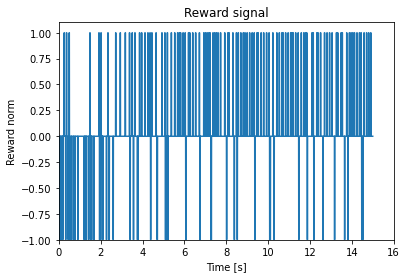

In [5]:
plt.figure()
plt.plot(sim.trange(), sim.data[reward_probe])
plt.xlim(0, 16)
plt.ylim(bottom=-1)
plt.title("Reward signal")
plt.xlabel("Time [s]")
plt.ylabel("Reward norm")

### 3. A continuous state grid world example

In this model:
- the agent always moves randomly, it's not *using* what
it learns to change its movement (it is just trying to anticipate future rewards)
- the agent is given a reward whenever it is in the green square, and a 
punishment (negative reward) whenever it is in the red square  
- it learns to anticipate the reward/punishment as shown in the value graph
- we convert the error rule into the continuous domain by using a long time constant for s-1
and a short time constant for s as before.

In [15]:
import grid

mymap="""
#######
#     #
# # # #
# # # #
#G   R#
#######
"""


world = grid.World(grid.GridCell, map=mymap, directions=4)
body = grid.ContinuousAgent()
world.add(body, x=1, y=2, dir=2)

tau=0.1


In [6]:
def move(t, x):
    '''Defines a continuous action policy for the agent'''
    speed, rotation = x
    dt = 0.001
    max_speed = 20.0
    max_rotate = 10.0
    body.turn(rotation * dt * max_rotate)
    body.go_forward(speed * dt * max_speed)
    
    if int(body.x) == 1:
        world.grid[4][4].wall = True
        world.grid[4][2].wall = False
    if int(body.x) == 4:
        world.grid[4][2].wall = True
        world.grid[4][4].wall = False

def sensor(t):
    '''Obtain environment state using sensors'''
    angles = (np.linspace(-0.5, 0.5, 3) + body.dir) % world.directions
    return [body.detect(d, max_distance=4)[0] for d in angles]

def braiten(x):
    '''Compute input to movement function based on sensor'''
    turn = x[2] - x[0]
    spd = x[1] - 0.5
    return spd, turn

def position_func(t):
    '''Create unit normalized state representation of grid world'''
    return body.x / world.width * 2 - 1, 1 - body.y / world.height * 2, body.dir / world.directions

In [7]:
with nengo.Network(seed=2) as model:
    env = grid.GridNode(world, dt=0.005)

    # define nodes and ensembles for managing action policy
    movement = nengo.Node(move, size_in=2)
    stim_radar = nengo.Node(sensor)
    
    radar = nengo.Ensemble(n_neurons=50, dimensions=3, radius=4, seed=2,
                           noise=nengo.processes.WhiteSignal(10, 0.1, rms=1))
    
    nengo.Connection(stim_radar, radar)
    nengo.Connection(radar, movement, function=braiten)  
    
    # encode state information in ensemble of neurons
    position = nengo.Node(position_func)
    state = nengo.Ensemble(100, 3)
    
    nengo.Connection(position, state, synapse=None)
    
    reward = nengo.Node(lambda t: body.cell.reward)
        
    value = nengo.Ensemble(n_neurons=50, dimensions=1)

    # this sets up learning on our connection between state and value encodings
    learn_conn = nengo.Connection(state, value, function=lambda x: 0,
                                  learning_rule_type=nengo.PES(learning_rate=1e-4, pre_tau=tau))
    
    # this connection adds the reward to the learning signal
    nengo.Connection(reward, learn_conn.learning_rule, transform=-1, synapse=tau)
    
    # this connection adds the observed observed value
    nengo.Connection(value, learn_conn.learning_rule, transform=-0.9, synapse=0.01)
    
    # this connection substracts the predicted value
    nengo.Connection(value, learn_conn.learning_rule, transform=1, synapse=tau)

In [8]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'configs/learning6-value.py.cfg')

C:\Users\udayk\anaconda3\envs\custom-env\lib\site-packages\nengo\builder\optimizer.py:636: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn("Skipping some optimization steps because SciPy is "
